# Seasonal Variability of Hurricane Frequency and Max Wind Speed

This analysis aims to explore the seasonal variability of hurricane activity using the HURDAT2 dataset. I investigate how the number of hurricanes per month has changed from 1972 to present, as this is the period over which reliable data is available. The analysis is done per month to identify any specific periods within the year showing increases or decreases in hurricane frequency and max wind speed.

In [71]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [72]:
df = pd.read_parquet('data/hurdat2.parquet')

In [73]:
df = df.loc[(df.Year >= 1972)]

In [74]:
# Group by 'UniqueID' to reduce to unique hurricanes, taking max wind speed and month of occurrence
df_unique_hurricanes = df.groupby('UniqueID').agg({
    'MaxWind': 'max',    # Take the maximum wind speed for each hurricane
    'Month': 'first',    # Take the first month of occurrence
    'Year': 'first'      # Take the first year of occurrence
}).reset_index()

In [75]:
# Group the unique hurricanes by month and calculate counts and average intensity
monthly_counts = df_unique_hurricanes.groupby('Month').size().reset_index(name='Count')
monthly_counts_over_time = df_unique_hurricanes.groupby(['Year', 'Month']).size().reset_index(name='Count')

monthly_avg_intensity = df_unique_hurricanes.groupby('Month')['MaxWind'].mean().reset_index(name='AvgMaxIntensity')
monthly_intensity_over_time = df_unique_hurricanes.groupby(['Year', 'Month'])['MaxWind'].mean().reset_index(name='AvgMaxIntensity')

The figure below shows the total frequency of hurricanes by month over the period 1972-present. July sees the most hurricanes, followed by June, and August.

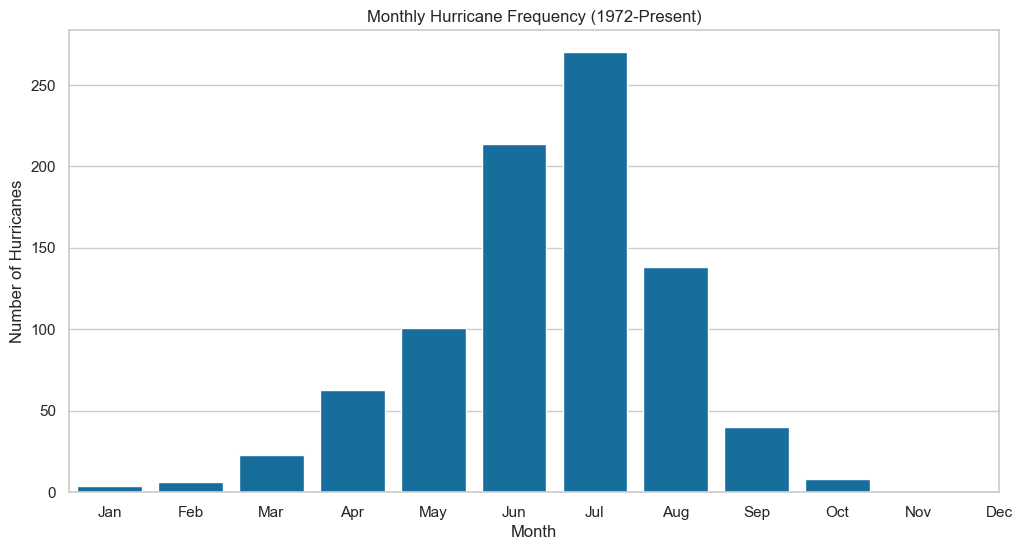

In [76]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Count', data=monthly_counts, color=sns.color_palette('colorblind')[0])
plt.xlabel('Month')
plt.ylabel('Number of Hurricanes')
plt.title('Monthly Hurricane Frequency (1972-Present)')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ha='center')
plt.show()

The figure below shows the average maximum frequency of hurricanes in each month. The avg max wind speed increases from April until the fall. There are very few hurricanes outside this time period, so although they are plotted I do not consider them of interest.

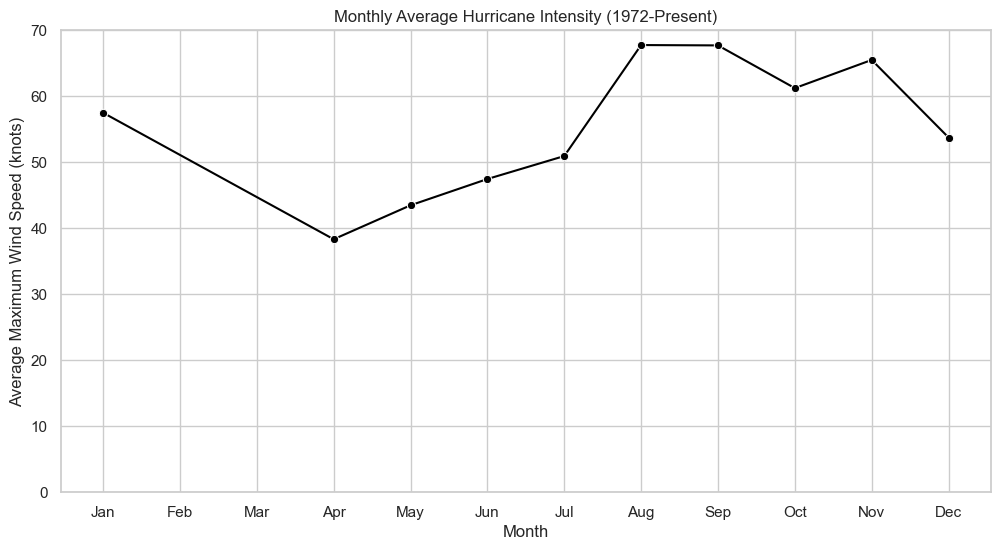

In [82]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='AvgMaxIntensity', data=monthly_avg_intensity, marker='o', color='black')
plt.xlabel('Month')
plt.ylabel('Average Maximum Wind Speed (knots)')
plt.title('Monthly Average Hurricane Intensity (1972-Present)')
plt.ylim(0, 70)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

Months with significant trends in hurricane frequency (p < 0.05):
Empty DataFrame
Columns: [Month, Slope, P-Value, Significant]
Index: []


<Figure size 1400x1000 with 0 Axes>

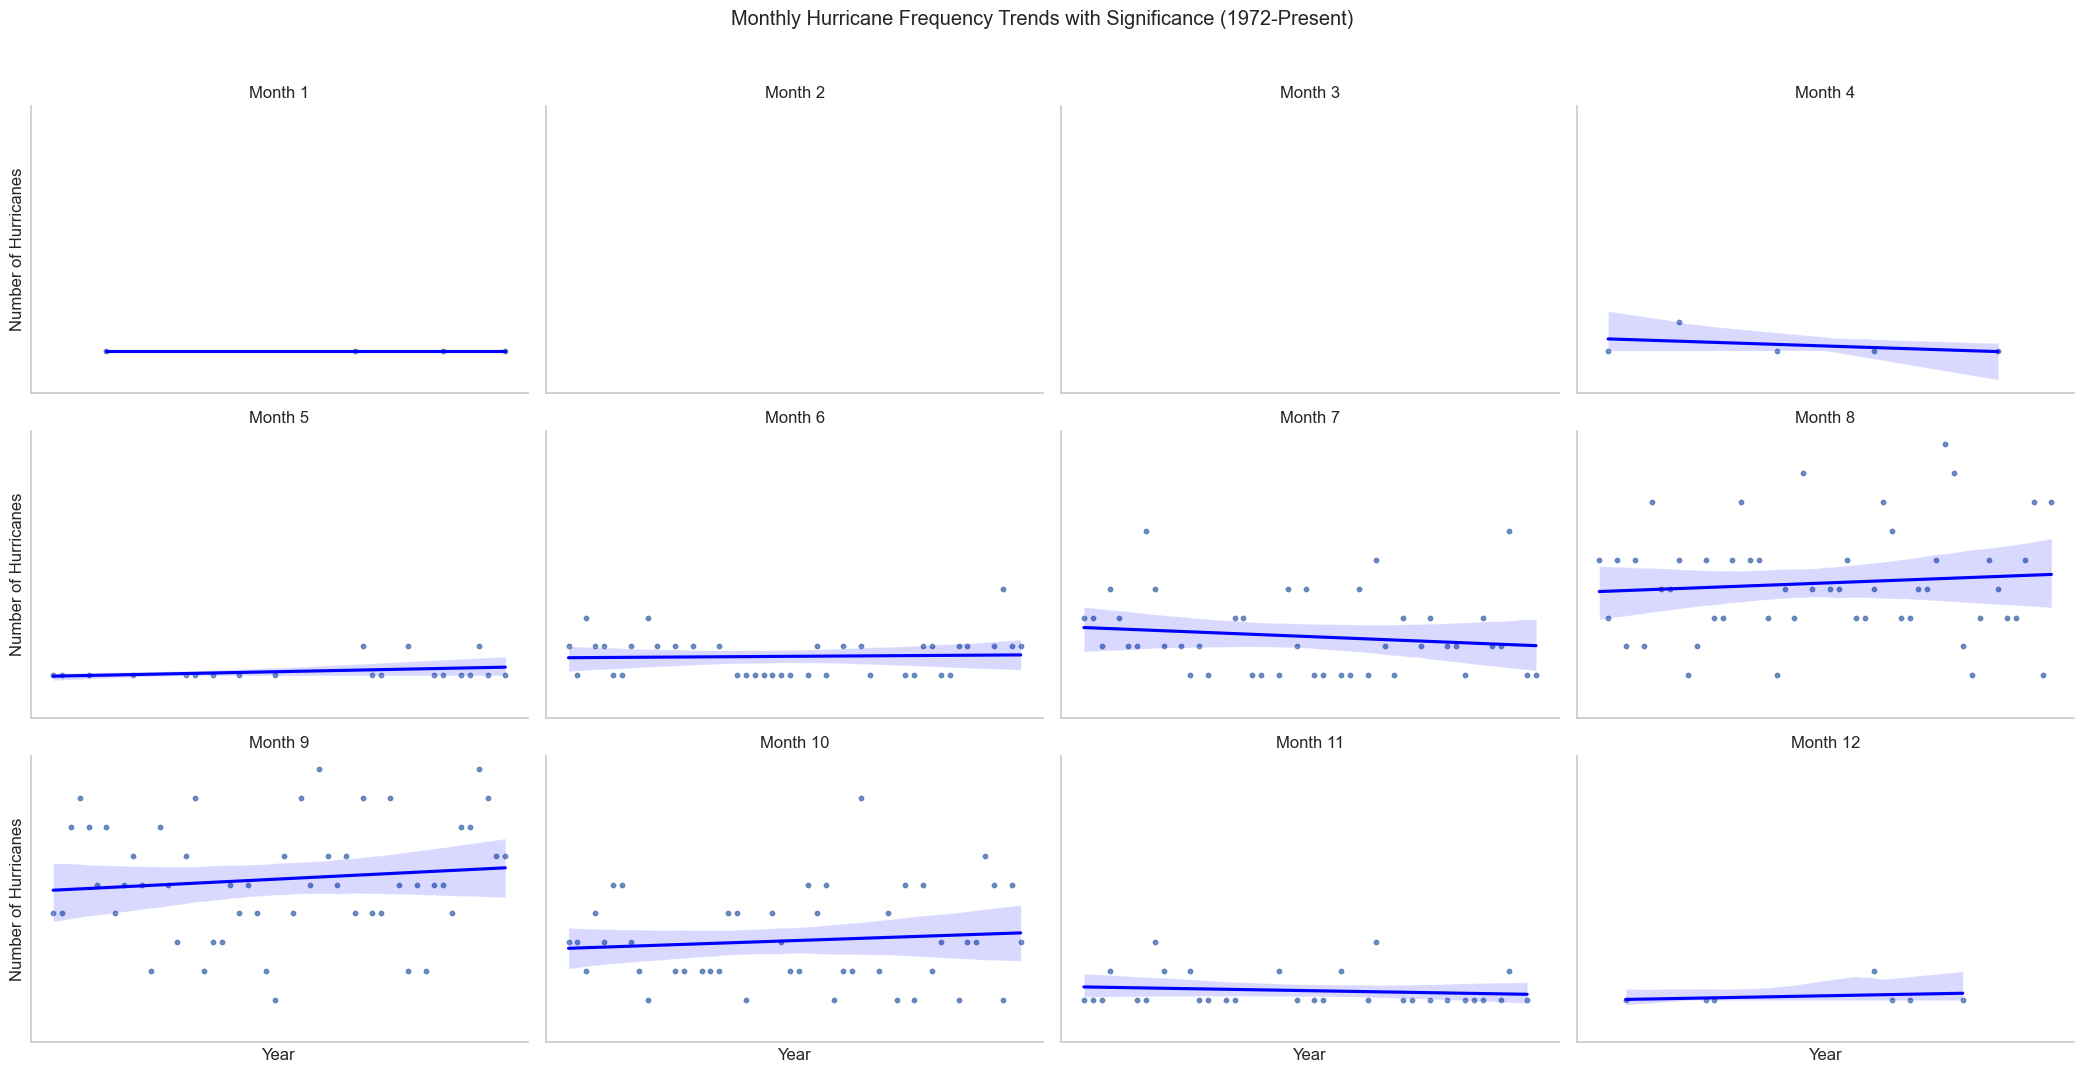

In [88]:
# Create a list to store the significance results for each month
significance_results = []

# Loop over each month and perform linear regression to determine if the slope is significantly different from zero
for month in range(1, 13):
    month_data = monthly_counts_over_time[monthly_counts_over_time['Month'] == month]
    
    # Check if data exists for the month, if not, continue to the next month
    if month_data.empty:
        continue
    
    # Perform linear regression on year vs. count
    slope, intercept, r_value, p_value, std_err = linregress(month_data['Year'], month_data['Count'])
    
    # Check if the slope is significantly different from zero (p < 0.05)
    significant = p_value < 0.05
    significance_results.append({
        'Month': month,
        'Slope': slope,
        'P-Value': p_value,
        'Significant': significant
    })

# Convert significance results to a DataFrame for easier handling and display
significance_df = pd.DataFrame(significance_results)

# Display the months that have a statistically significant trend
print("Months with significant trends in hurricane frequency (p < 0.05):")
print(significance_df[significance_df['Significant']])

# Plotting the trends for each month with regression lines, adding color to highlight significant trends
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create FacetGrid to show monthly trends, highlighting those with significant trends
g = sns.FacetGrid(monthly_counts_over_time, col="Month", col_wrap=4, height=3.5, aspect=1.5, col_order=range(1, 13))

# Loop through each month to plot with a regression line, color coding based on significance
for ax, month in zip(g.axes.flatten(), range(1, 13)):
    month_data = monthly_counts_over_time[monthly_counts_over_time['Month'] == month]
    
    if not month_data.empty:
        significant = significance_df[significance_df['Month'] == month]['Significant'].iloc[0]
        color = 'red' if significant else 'blue'
        sns.regplot(x='Year', y='Count', data=month_data, ax=ax, scatter_kws={'s': 10}, line_kws={'color': color})
        ax.set_title(f'Month {month}')
    else:
        # If no data for that month, set the title but leave the plot empty
        ax.set_title(f'Month {month}')
        ax.set_xticks([])
        ax.set_yticks([])

g.set_axis_labels("Year", "Number of Hurricanes")
g.fig.suptitle("Monthly Hurricane Frequency Trends with Significance (1972-Present)", y=1.02)
plt.tight_layout()

Above is a figure showing the number of hurricanes in each month vs year from 1972-present. I calculate and plot linear fits with uncertainties to each of these months and find that no months show statistically significant increases or decreases in hurricane frequency over this time period. No months have significant trends in hurricane frequency.

Months with significant trends in hurricane frequency (p < 0.05):
   Month     Slope   P-Value  Significant
1      4  0.740908  0.010219         True
3      6  0.524051  0.000900         True
4      7  0.456022  0.015665         True
6      9  0.497113  0.001516         True
7     10  0.672783  0.000491         True
8     11  0.795585  0.010390         True


<Figure size 1400x1000 with 0 Axes>

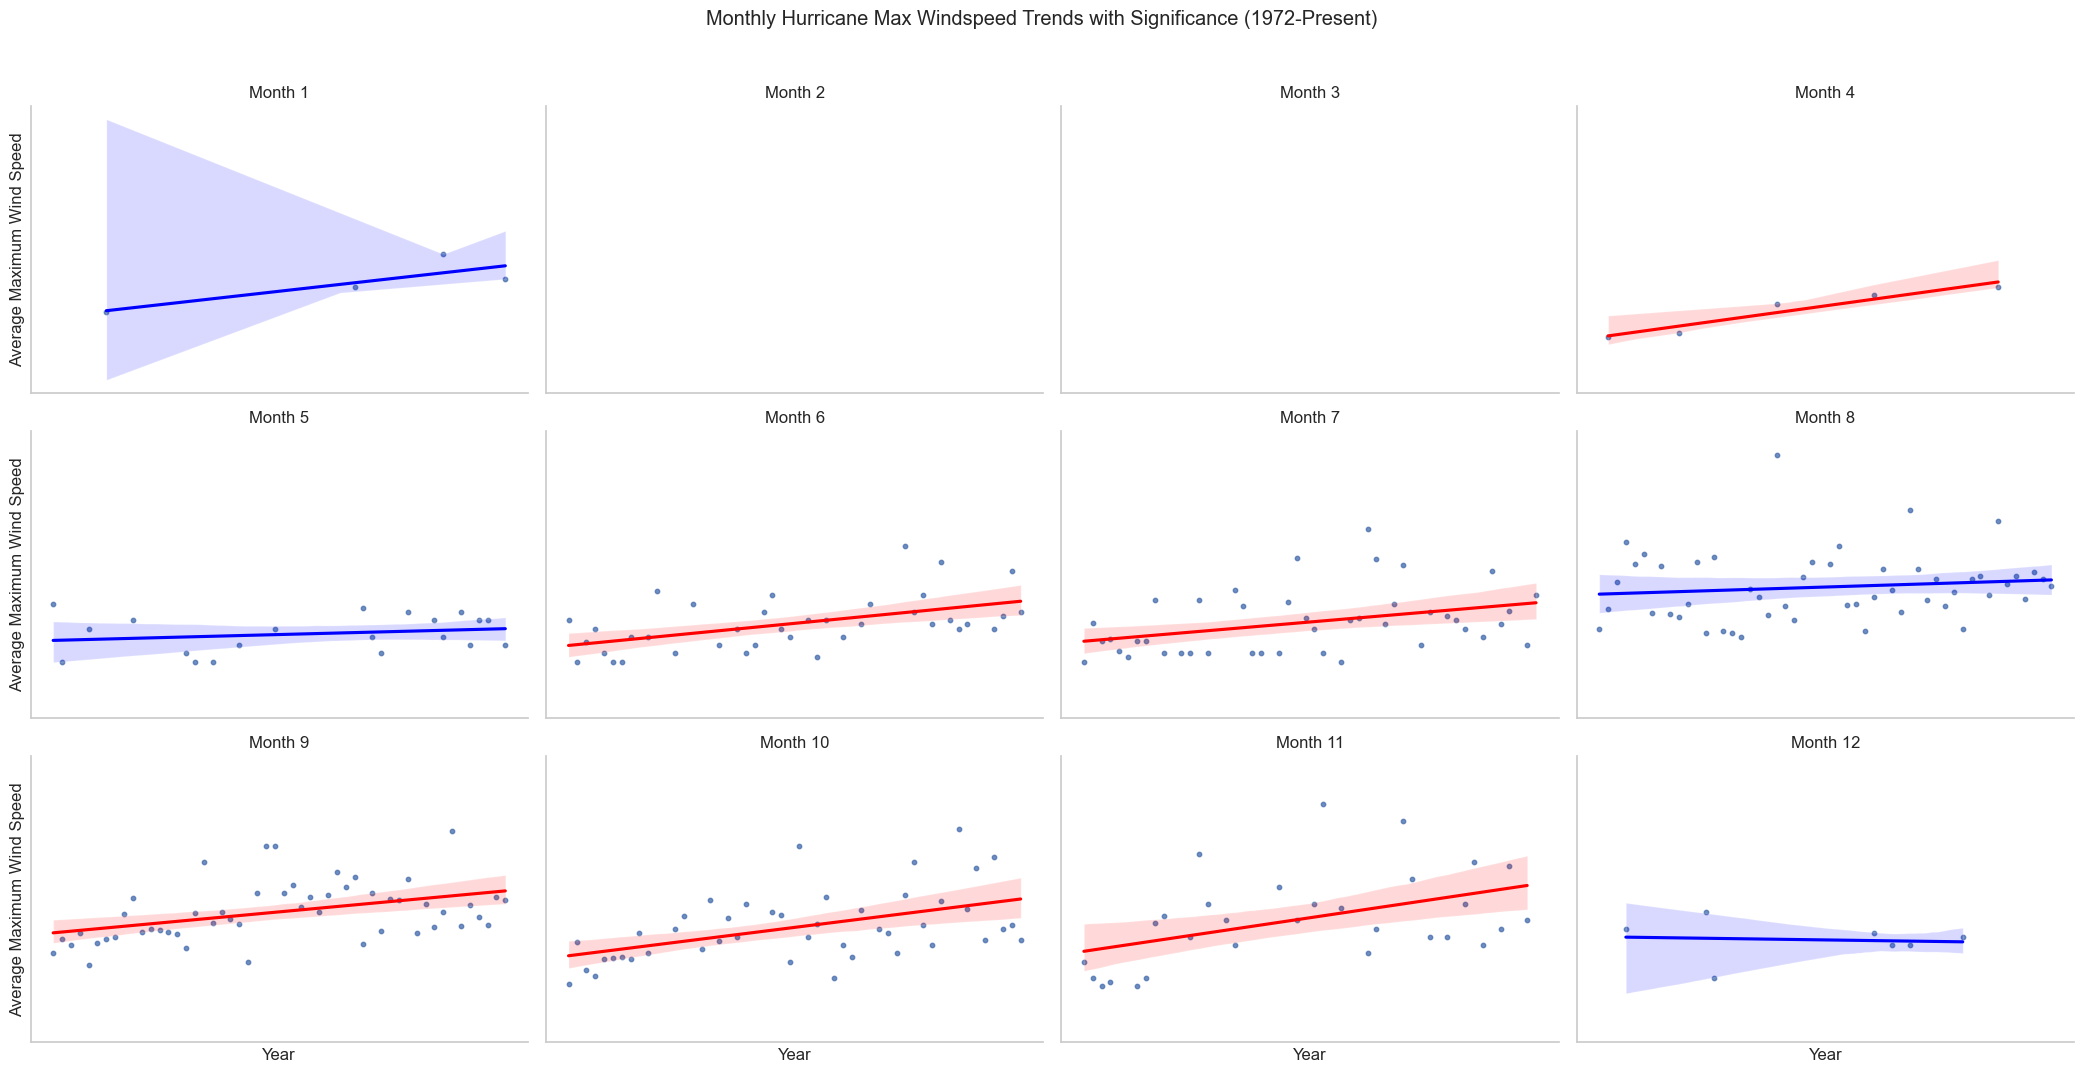

In [90]:
# Create a list to store the significance results for each month
significance_results = []

# Loop over each month and perform linear regression to determine if the slope is significantly different from zero
for month in range(1, 13):
    month_data = monthly_intensity_over_time[monthly_intensity_over_time['Month'] == month]
    
    # Check if data exists for the month, if not, continue to the next month
    if month_data.empty:
        continue
    
    # Perform linear regression on year vs. MaxIntensity
    slope, intercept, r_value, p_value, std_err = linregress(month_data['Year'], month_data['AvgMaxIntensity'])
    
    # Check if the slope is significantly different from zero (p < 0.05)
    significant = p_value < 0.05
    significance_results.append({
        'Month': month,
        'Slope': slope,
        'P-Value': p_value,
        'Significant': significant
    })

# Convert significance results to a DataFrame for easier handling and display
significance_df = pd.DataFrame(significance_results)

# Display the months that have a statistically significant trend
print("Months with significant trends in hurricane frequency (p < 0.05):")
print(significance_df[significance_df['Significant']])

# Plotting the trends for each month with regression lines, adding color to highlight significant trends
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create FacetGrid to show monthly trends, highlighting those with significant trends
g = sns.FacetGrid(monthly_intensity_over_time, col="Month", col_wrap=4, height=3.5, aspect=1.5, col_order=range(1, 13))

# Loop through each month to plot with a regression line, color coding based on significance
for ax, month in zip(g.axes.flatten(), range(1, 13)):
    month_data = monthly_intensity_over_time[monthly_intensity_over_time['Month'] == month]
    
    if not month_data.empty:
        significant = significance_df[significance_df['Month'] == month]['Significant'].iloc[0]
        color = 'red' if significant else 'blue'
        sns.regplot(x='Year', y='AvgMaxIntensity', data=month_data, ax=ax, scatter_kws={'s': 10}, line_kws={'color': color})
        ax.set_title(f'Month {month}')
    else:
        # If no data for that month, set the title but leave the plot empty
        ax.set_title(f'Month {month}')
        ax.set_xticks([])
        ax.set_yticks([])

g.set_axis_labels("Year", "Average Maximum Wind Speed")
g.fig.suptitle("Monthly Hurricane Max Windspeed Trends with Significance (1972-Present)", y=1.02)
plt.tight_layout()

Above is a figure showing the average maximum wind speed of hurricanes in each month vs year from 1972-present. I calculate and plot linear fits with uncertainties to each of these months. Fits shown in red highlight months where there are statistically significant increases in average maximum wind speeds, and fits shown in blue highlight months where there is no statistically significant increase.

April, June, September, October and November have statistically significant increasing max wind speeds. While the number of hurricanes is not increasing with time, their intensities are.